In [8]:
import matplotlib.pyplot as plt
import numpy    as np
import torch    as tc
import qutip    as qt
import pandas   as pd
import torch.nn as nn
import random
import matplotlib.ticker as ticker

from tqdm import tqdm

In [9]:
########################################### FUNCTION for run de algorithm ##################################################  

def data_qubit_two_crosstalk(lista_J,dissipation,tfinal,N,O_op,device="cpu"):
    # Operadores de Pauli para cada qubit
    XX,XY,XZ = qt.tensor(qt.sigmax(),qt.sigmax()),qt.tensor(qt.sigmax(),qt.sigmay()),qt.tensor(qt.sigmax(),qt.sigmaz())
    YX,YY,YZ = qt.tensor(qt.sigmay(),qt.sigmax()),qt.tensor(qt.sigmay(),qt.sigmay()),qt.tensor(qt.sigmay(),qt.sigmaz())
    ZX,ZY,ZZ = qt.tensor(qt.sigmaz(),qt.sigmax()),qt.tensor(qt.sigmaz(),qt.sigmay()),qt.tensor(qt.sigmaz(),qt.sigmaz())
    operadores = [XX,XY,XZ, YX,YY,YZ,ZX,ZY,ZZ]
    
    H = 0
    for i in range(len(lista_J)):
        H += 0.5*lista_J[i]*operadores[i]

    # Hamiltonian Lindbladian
    c_ops = [np.sqrt(dissipation[0])*qt.tensor(qt.sigmam(), qt.qeye(2)),
             np.sqrt(dissipation[1])*qt.tensor(qt.sigmaz(), qt.qeye(2)),
             np.sqrt(dissipation[2])*qt.tensor(qt.qeye(2) , qt.sigmam()),
             np.sqrt(dissipation[3])*qt.tensor(qt.qeye(2) , qt.sigmaz()),]
    # Estado inicial (cada qubit na superposição de |0> e |1>)
    # |+> = (|0> + |1>)/sqrt(2)
    theta1  = np.pi/4
    phi1    = 0.0 #np.pi/3
    ket_plus1 = (np.cos(theta1)*qt.basis(2, 0)+np.sin(theta1)*np.exp(1j*phi1)*qt.basis(2, 1))
    theta2  = np.pi/4
    phi2    = 0.0 #np.pi/5
    ket_plus2 = (np.cos(theta2)*qt.basis(2, 0)+np.sin(theta2)*np.exp(1j*phi2)*qt.basis(2, 1))

    psi0 = qt.tensor(ket_plus1, ket_plus2)
    
    # Lista de tempos para a evolução
    tlist = np.linspace(0.0, tfinal, N)

    # Solução da equação de Schrödinger
    options = qt.Options(nsteps = 100000, atol = 1e-14, rtol = 1e-14)
    result  = qt.mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=O_op,options=options)

    expect  = tc.tensor( np.array( result.expect),device = device).transpose(0, 1)
    return expect



O_op =[ qt.tensor(qt.qeye(2) , qt.sigmax()),
        qt.tensor(qt.qeye(2) , qt.sigmay()),
        qt.tensor(qt.qeye(2) , qt.sigmaz()),
        qt.tensor(qt.sigmax(), qt.qeye(2) ),
        qt.tensor(qt.sigmax(), qt.sigmax()),
        qt.tensor(qt.sigmax(), qt.sigmay()),
        qt.tensor(qt.sigmax(), qt.sigmaz()),
        qt.tensor(qt.sigmay(), qt.qeye(2) ),
        qt.tensor(qt.sigmay(), qt.sigmax()),
        qt.tensor(qt.sigmay(), qt.sigmay()),
        qt.tensor(qt.sigmay(), qt.sigmaz()),
        qt.tensor(qt.sigmaz(), qt.qeye(2) ),
        qt.tensor(qt.sigmaz(), qt.sigmax()),
        qt.tensor(qt.sigmaz(), qt.sigmay()),
        qt.tensor(qt.sigmaz(), qt.sigmaz()),
        ]

In [10]:
parametros_gamma= ['gamma1', 'gamma2', 'gamma3', 'gamma4']
parametros_J    = ['JXX', 'JXY', 'JXZ', 'JYX', 'JYY', 'JYZ', 'JZX', 'JZY', 'JZZ']

erro = []
for i in range(5, 101):
    caminho     = f'C:/Users/Gubio/CODESACE/Pinn inverse for opem quantum system/No fields/data/parametro_nofields_N50_seed{i}_std0.02.csv'
    df          = pd.read_csv(caminho, index_col=0)
    valor_real  = df['treino'].str.strip('[]').astype(float) 
    valor_previsto = df['previsto'].str.strip('[]').astype(float) 
    
    erro_abs    = (valor_real - valor_previsto)**2#np.abs(valor_real - valor_previsto)/ np.abs(valor_real)
    
    erro.append(erro_abs.to_numpy())

# Média, mínimo e máximo dos erros para cada parâmetro
erro_max   = np.max(erro,0)
erro_mean  = np.mean(erro,0) 
erro_min   = np.min(erro,0)

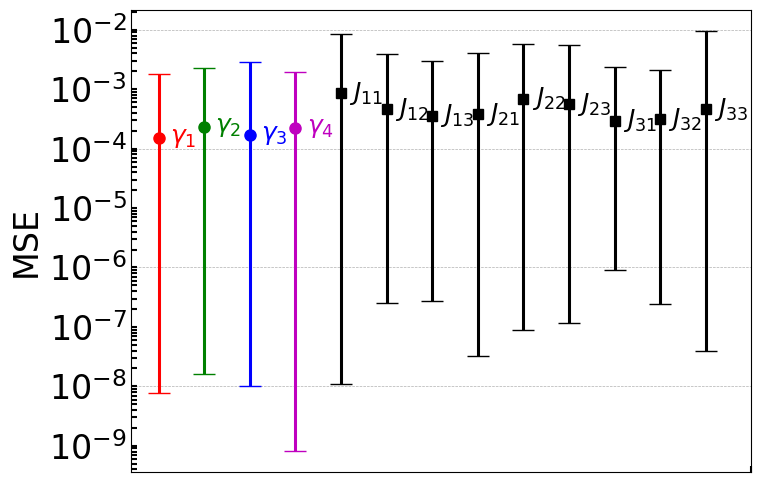

In [11]:
parametros_gamma= [r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$']
parametros_J    = [r'$J_{11}$', r'$J_{12}$', r'$J_{13}$', r'$J_{21}$', r'$J_{22}$', r'$J_{23}$', r'$J_{31}$', r'$J_{32}$',r'$J_{33}$']
# Plot
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(8,6))
Nc_arr = np.array(parametros_gamma +parametros_J)
# Plot Js médio com traço mais espesso

# yerr_J = [erro_mean - erro_min, erro_max - erro_mean]
# plt.errorbar(Nc_arr, erro_mean, yerr=yerr_J, fmt='ks', capsize=8, linewidth=2.2)

# --- 4 primeiros: cores e marcador 'o' ---
colors  = ['r','g','b','m']
for i, c in enumerate(colors):
    plt.errorbar(Nc_arr[i], erro_mean[i],
                 yerr=[[erro_mean[i] - erro_min[i]], [erro_max[i] - erro_mean[i]]],
                 fmt='o', color=c, capsize=8, linewidth=2.2, markersize=8, zorder=3)
    # rótulo ao lado do marcador
    plt.annotate(parametros_gamma[i], xy=(Nc_arr[i], erro_mean[i]),
                 xytext=(8, 0), textcoords='offset points',
                 ha='left', va='center', color=c, fontsize=18, zorder=4)

# --- Demais: pretos com marcador 's' ---
for j in range(4, len(Nc_arr)):
    plt.errorbar(Nc_arr[j], erro_mean[j],
                 yerr=[[erro_mean[j] - erro_min[j]], [erro_max[j] - erro_mean[j]]],
                 fmt='s', color='k', capsize=8, linewidth=2.2, markersize=7, zorder=3)
    plt.annotate(Nc_arr[j], xy=(Nc_arr[j], erro_mean[j]),
                 xytext=(6, 0), textcoords='offset points',
                 ha='left', va='center', color='k', fontsize=18, zorder=4)

plt.yscale('log')
plt.ylabel('MSE')  
plt.xticks([""])

plt.tick_params( axis='both', which='both', direction='in', length=4, width=1.5)
# plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
# Definindo os ticks logarítmicos manualmente
ax = plt.gca()
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=None, numticks=10))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10))

plt.savefig("erro_parametros_nofields.pdf", dpi=500, bbox_inches='tight')
plt.show()

In [12]:
parametros_gamma= ['gamma1', 'gamma2', 'gamma3', 'gamma4']
parametros_J    = ['JXX', 'JXY', 'JXZ', 'JYX', 'JYY', 'JYZ', 'JZX', 'JZY', 'JZZ']

erro = []
erroMAPE = []
for i in range(5, 101):
    caminho     = f'C:/Users/Gubio/CODESACE/Pinn inverse for opem quantum system/No fields/data/parametro_nofields_N50_seed{i}_std0.02.csv'
    df          = pd.read_csv(caminho, index_col=0)
    valor_real  = df['treino'].str.strip('[]').astype(float) 
    valor_previsto = df['previsto'].str.strip('[]').astype(float) 
    
    erro_abs    = (valor_real[parametros_gamma] - valor_previsto[parametros_gamma])#np.abs(valor_real - valor_previsto)/ np.abs(valor_real)
    
    erro.append(erro_abs.to_numpy())

    erroMAPE.append(np.abs(valor_real[parametros_gamma] - valor_previsto[parametros_gamma])/ np.abs(valor_real[parametros_gamma]))
erro = np.array(erro)
print("MSE: ", np.mean((erro)**2))
print("MAE: ", np.mean(abs(erro)))
print("MAPE(%): ", np.mean(erroMAPE)*100)


MSE:  0.0001951579919942802
MAE:  0.010304755397684535
MAPE(%):  4.127295407815406


In [13]:
parametros_gamma= ['gamma1', 'gamma2', 'gamma3', 'gamma4']
parametros_J    = ['JXX', 'JXY', 'JXZ', 'JYX', 'JYY', 'JYZ', 'JZX', 'JZY', 'JZZ']

erro = []
erroMAPE = []
for i in range(5, 101):
    caminho     = f'C:/Users/Gubio/CODESACE/Pinn inverse for opem quantum system/No fields/data/parametro_nofields_N50_seed{i}_std0.02.csv'
    df          = pd.read_csv(caminho, index_col=0)
    valor_real  = df['treino'].str.strip('[]').astype(float) 
    valor_previsto = df['previsto'].str.strip('[]').astype(float) 
    
    erro_abs    = (valor_real[parametros_J] - valor_previsto[parametros_J])#np.abs(valor_real - valor_previsto)/ np.abs(valor_real)
    
    erro.append(erro_abs.to_numpy())

    erroMAPE.append(np.abs(valor_real[parametros_J] - valor_previsto[parametros_J])/ np.abs(valor_real[parametros_J]))
erro = np.array(erro)
print("MSE: ", np.mean((erro)**2))
print("MAE: ", np.mean(abs(erro)))
print("MAPE(%): ", np.mean(erroMAPE)*100)


MSE:  0.0004859978568535583
MAE:  0.016368688224367937
MAPE(%):  12.017348442848503
